## Install necessary packages

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import norm
from scipy.signal import convolve
from scipy.signal import find_peaks

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
filename = "/content/drive/MyDrive/Colab Notebooks/spike_data.csv"
fs = 12500

## Convert Axion Biosystem's spike_list.csv file into a dataframe

In [4]:
def organize_spikelist(filepath):
    # Create neuralMetric dataframe
    spikelist_file = pd.read_csv(filepath, sep='\r\n', header=None)
    spikelist_file = spikelist_file[0].str.split(',', expand=True)
    spikelist_file.columns = spikelist_file.iloc[0]
    spikelist_file = spikelist_file.iloc[1:]

    spiketimes = spikelist_file[["Time (s)", "Electrode"]]
    spiketimes = spiketimes.iloc[:-8]
    spiketimes = spiketimes.dropna()
    spiketimes = spiketimes[spiketimes["Electrode"].str.contains("_")]
    spiketimes = spiketimes.astype({"Time (s)": float})
    spiketimes["Well"] = [electrode.split("_")[0] for electrode in list(spiketimes["Electrode"].values)]
    spiketimes["Channel"] = [electrode.split("_")[1] for electrode in list(spiketimes["Electrode"].values)]

    r,c = np.where(spikelist_file == "Well Information")
    metadata_slice = spikelist_file.iloc[r[0]:].transpose().reset_index()
    metadata_slice.columns = metadata_slice.iloc[0]
    metadata_slice = metadata_slice.iloc[1:]
    metadata = {}
    label = []
    for i, well in enumerate(metadata_slice["Well"]):
        if well != None:
            metadata[well] = metadata_slice.iloc[i]["Treatment"]
            label.append(str(well)+"-"+str(metadata_slice.iloc[i]["Treatment"]))

    return spiketimes, metadata, label

spiketimes, metadata, label = organize_spikelist(filename)

<ipython-input-4-4aef381c3626>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  spikelist_file = pd.read_csv(filepath, sep='\r\n', header=None)


In [5]:
spiketimes.head()

,Time (s),Electrode,Well,Channel
1,0.00184,A1_76,A1,76
2,0.00824,C1_51,C1,51
3,0.01160,B1_47,B1,47
4,0.01984,A1_42,A1,42
5,0.02224,C1_41,C1,41


In [6]:
spiketimes["Well"].unique()

array(['A1', 'C1', 'B1', 'A4', 'C2', 'B2', 'B4', 'A2', 'C3', 'C4', 'B3',
       'A3'], dtype=object)

In [7]:
spiketimes["Channel"].unique()

array(['76', '51', '47', '42', '41', '16', '26', '13', '18', '31', '84',
       '44', '82', '38', '85', '32', '88', '78', '11', '72', '87', '75',
       '48', '62', '24', '65', '63', '25', '15', '43', '81', '61', '46',
       '58', '83', '55', '57', '52', '12', '73', '22', '56', '67', '77',
       '66', '53', '36', '74', '86', '45', '23', '33', '21', '14', '71',
       '17', '37', '35', '28', '54', '27', '34', '68', '64'], dtype=object)

In [8]:
duration = int(math.ceil(max(spiketimes["Time (s)"])/100.0))*100
print(f"It appears the duration of these recordings was {duration} seconds.")

It appears the duration of these recordings was 300 seconds.


The data that we'll be dealing with are spike times from a 12-well multielectrode array system. Each well contains 64 channels (arranged in an 8x8 grid). Channels are labeled according to a cartesian coordinate system where the first digit represents x (or the row) and the second digit represents y (or the column).

## Select a well to analyze
This is where you would start wrapping the below code into a loop that iterates through each well, each plate/recording.

In [9]:
well_id = "A3"

## Quick look at the network activity
Here we are plotting a histogram of spike times from the well we selected, using a bin size of 0.1 seconds (300 second duration/3000 bins).

Text(0.5, 1.0, 'Sort of like a PSTH - representing network activity')

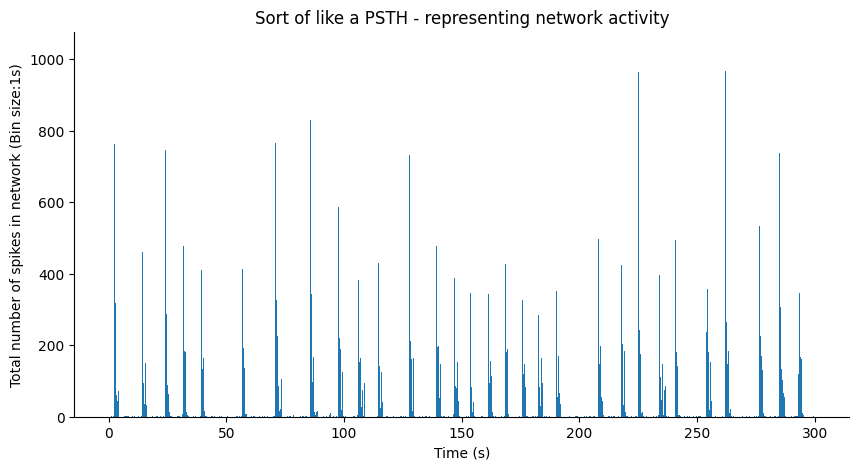

In [10]:
plt.figure(figsize=(10,5))
plt.hist(spiketimes[spiketimes["Well"]==well_id]["Time (s)"], bins=3000);
sns.despine()
plt.xlabel("Time (s)")
plt.ylabel("Total number of spikes in network (Bin size:1s)")
plt.title("Sort of like a PSTH - representing network activity")

It looks like there is some interesting network bursting activity! Are these reverberating super bursts (RSB) like the ones mentioned in Pradeepan et al., 2023? 😂

Jokes aside, the code below will help identify whether this is or isn't an RSB. But for now, we'll plot a close up of a smaller window.

Text(0.5, 1.0, 'Multiple peaks within a network event')

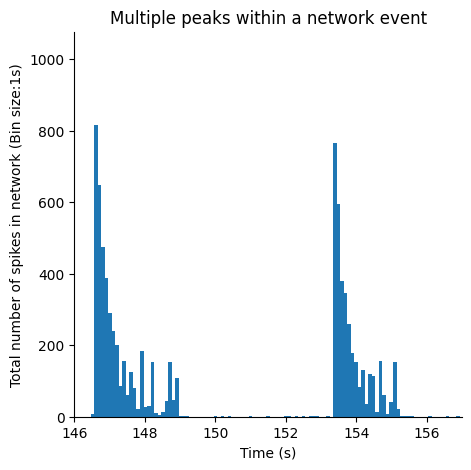

In [11]:
# Definitely do not keep plotting histograms with large bin sizes if you want your code to run fast
plt.figure(figsize=(5,5))
plt.hist(spiketimes[spiketimes["Well"]==well_id]["Time (s)"], bins=3000);
sns.despine()
plt.xlim(146, 157)
plt.xlabel("Time (s)")
plt.ylabel("Total number of spikes in network (Bin size:1s)")
plt.title("Multiple peaks within a network event")

## Sort data frame containing mixed-bag of electrode and spike times based on channel name


In [12]:
channel_ids = [i for j in range(1, 9) for i in range(j * 10 + 1, j * 10 + 9)]
'''
The above produces the following:
  [11, 12, 13, 14, 15, 16, 17, 18,
  21, 22, 23, 24, 25, 26, 27, 28,
  31, 32, 33, 34, 35, 36, 37, 38,
  41, 42, 43, 44, 45, 46, 47, 48,
  51, 52, 53, 54, 55, 56, 57, 58,
  61, 62, 63, 64, 65, 66, 67, 68,
  71, 72, 73, 74, 75, 76, 77, 78,
  81, 82, 83, 84, 85, 86, 87, 88]
'''

def generate_raster(spiketimes, well_id, duration, channel_ids):
  '''
  well_data: Data frame in the format seen above
  duration: Length of recording in seconds (in this case 300 seconds)
  channel_ids: Name of all channels in the format seen in the data frame "channel" column
  '''
  raster = []
  # Loop through each channel regardless of activity
  well_spiketimes = spiketimes[spiketimes["Well"] == well_id].reset_index(drop=True)
  for channel in channel_ids:
    # If the channel is found in my data (i.e., it had at least 1 spike)
    if str(channel) in well_spiketimes["Channel"].to_list():
      # Find spike times associated with that channel
      spiketrain = well_spiketimes.loc[well_spiketimes["Channel"]==str(channel), well_spiketimes.columns.str.contains("Time")].reset_index(drop=True)
      # Convert spike times that occur before the end of the recording (i.e., duration) to an array
      spiketrain = spiketrain.to_numpy().flatten()[spiketrain.to_numpy().flatten() <= duration]
      # Store array
      raster.append(spiketrain)
    # If the channel is not found in my data, I still want to store that it was empty
    else:
      raster.append([])
  return raster

raster = generate_raster(spiketimes, well_id, duration, channel_ids)

## Visualize network activity (as a raster plot)

Text(0.5, 0, 'Time (s)')

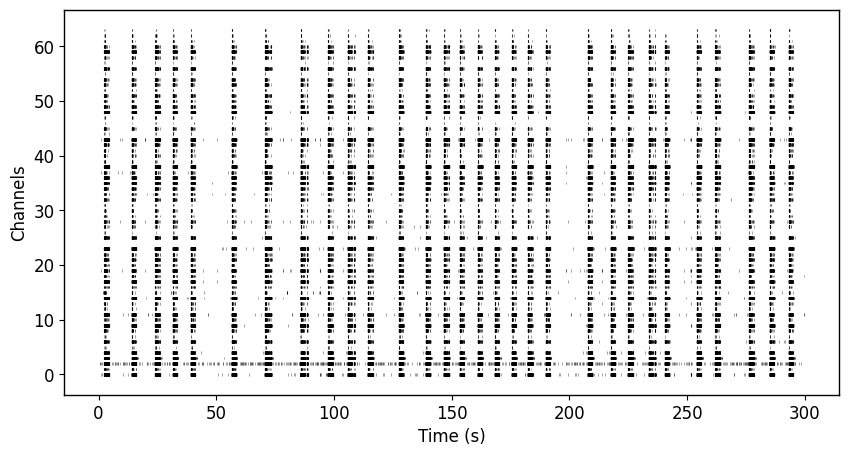

In [13]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);
plt.ylabel("Channels")
plt.xlabel("Time (s)")

We did it with the histogram, might as well do it with the raster. 🤷

Text(0.5, 0, 'Time (s)')

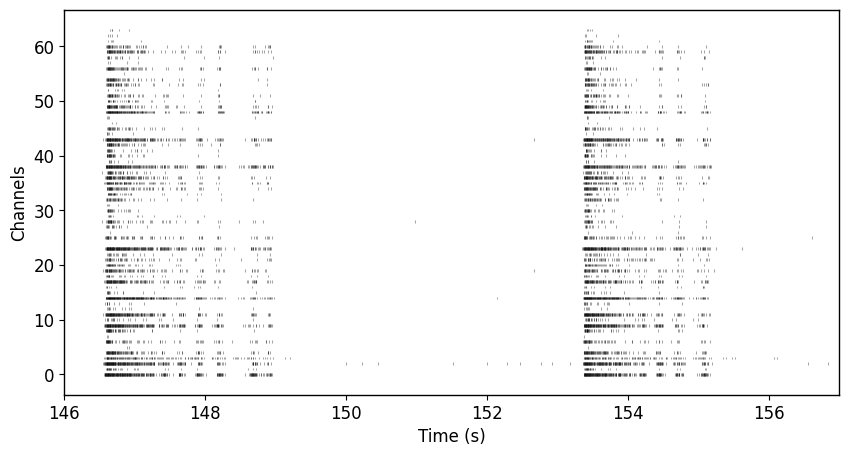

In [14]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);
plt.xlim(146, 157)
plt.ylabel("Channels")
plt.xlabel("Time (s)")

## Approach 1: Generate spike density function

### Gaussian Kernel
Note: You should be using a bandwidth optimized kernel. Refer to Shimazaki & Shinomoto, 2010)

In [15]:
def generate_gaussian_kernel(sigma=0.1, fs=12500):
    '''
    :param sigma: Width of kernel
    :param fs: Sampling frequency in Hz
    :return: Gaussian kernel
    '''
    edges = np.arange(-3 * sigma, 3 * sigma, 1 / fs)
    kernel = norm.pdf(edges, 0, sigma)
    kernel = kernel / max(kernel)
    return kernel

### Binary spike matrix
Create a matrix of nChannels x Y time points, where Y is the duration * sampling frequency.
Each cell will contain either a 0 or 1 depending on whether a spike was found i.e., 1 or not i.e., 0.

In [16]:
def generate_spikematrix(spiketrain, fs=12500, duration=300):
    '''
    :param spiketrain: Takes spikes times from a single channel
    :param fs: Sampling frequency in Hz
    :param duration: Duration of recording in seconds
    :return: spikematrix: Binary matrix containing spikes
    '''
    spiketimes = np.array(spiketrain)
    spiketimes = spiketimes[spiketimes <= duration]  # Ensure recording is desired length
    spikematrix = [0] * (duration * fs)  # Generate empty spike matrix with appropriate number of bins
    for spike in spiketimes:
        spikematrix[int(spike * fs)] = 1
    return spikematrix

### Convolve gaussian kernel and spike matrix


In [17]:
def generate_sdf(spikematrix, gaussian_kernel):
    '''
    :param spikematrix: Binary matrix containing spikes
    :param gaussian_kernel: Gaussian kernel to be convolved with spikematrix
    :return: sdf: Continuous timeseries representing probability distribution of activity
    '''
    sdf_tmp = convolve(spikematrix, gaussian_kernel)
    sdf = sdf_tmp[int((len(sdf_tmp)-len(spikematrix))/2):int(len(sdf_tmp)-((len(sdf_tmp)-len(spikematrix))/2))]
    sdf = sdf/max(gaussian_kernel)
    return sdf

### Iterate through each channel, and generate the channel's SDF
Convolution takes some time because the spike matrix is quite large. There is a way to avoid spike density function generation by relying solely on histograms (like you saw above) but the timing of network event boundaries will be less precise.

In [18]:
kernel = generate_gaussian_kernel(sigma=0.075)

maxFR, channel_sdf = [], []
for n, channel in enumerate(channel_ids):
  spiketrain = raster[n]
  channel_spikematrix = generate_spikematrix(spiketrain, fs=12500, duration=duration)
  sdf_tmp = generate_sdf(channel_spikematrix, kernel)
  channel_sdf.append(sdf_tmp)
  maxFR.append(max(sdf_tmp))

In [19]:
network_sdf = np.mean(channel_sdf, axis=0)
weighted_network_sdf = np.average(channel_sdf, axis=0, weights=maxFR)

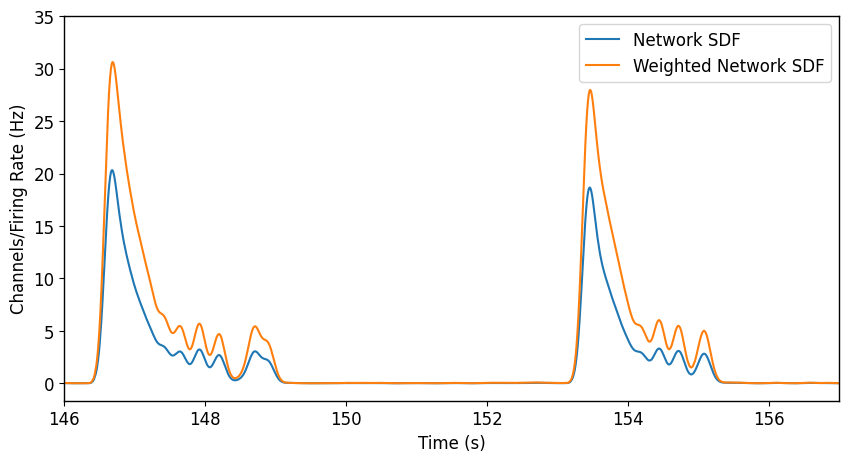

In [20]:
plt.figure(figsize=(10,5))
t = np.arange(0,duration,1/12500)
plt.plot(t,network_sdf)
plt.plot(t,weighted_network_sdf)
plt.xlim(146, 157)
plt.ylabel("Channels/Firing Rate (Hz)")
plt.xlabel("Time (s)")
plt.legend(["Network SDF", "Weighted Network SDF"])

As you can see, the general shape of the spike density function (which is an estimate of the network's instantaneous firing rate) is the same between the non-maxFR-weighted SDF and the maxFR-weighted SDF. You can use whichever one, but I prefer to use the maxFR-weighted SDF because it helps improve signal:noise for subsequent analysis.

## Visualize raster plot and spike density function

Text(0.5, 0, 'Time (s)')

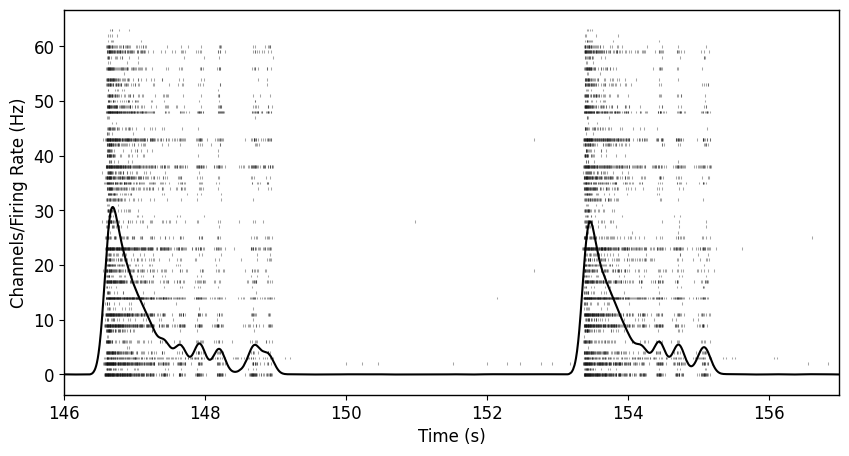

In [21]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);
t = np.arange(0,duration,1/12500)
plt.plot(t,weighted_network_sdf, color='black')
plt.xlim(146, 157)
plt.ylabel("Channels/Firing Rate (Hz)")
plt.xlabel("Time (s)")

As you can see, generally the spike density function does a really good job of representing the average activity across the network. You may notice that the "ramp-up" prior to each network burst starts before activity has truly started. This is largely an artifact of the gaussian kernel. To avoid this, you can use an alpha function or any function that you feel represents the probability of an action potential the best. For this example, and generally most purposes, a gaussian kernel will suffice.

# Reverberating Network Detection

## Did this network have a sufficiently high firing rate to warrant further analysis?

In [22]:
isBursting = False
BURST_THRESHOLD = 5
if max(weighted_network_sdf) >= BURST_THRESHOLD:
  isBursting = True

print(f"Is Network Bursting? {isBursting}")

Is Network Bursting? True


## Peak detection

In [23]:
def detect_burst_peaks(sdf, delta=0.5, fs=12500):
    '''
    :param sdf: Spike density function
    :param fr: Minimum average firing rate (amplitude in SDF) required to be considered a burst
    :return: Burst peak times
    '''
    burst_peaks, _ = find_peaks(sdf, prominence=delta)
    return burst_peaks/fs

In [24]:
burst_peak_times = []
if isBursting:
  burst_peak_times = detect_burst_peaks(weighted_network_sdf)
print(f"Detected {len(burst_peak_times)} potential network bursts.")

Detected 145 potential network bursts.


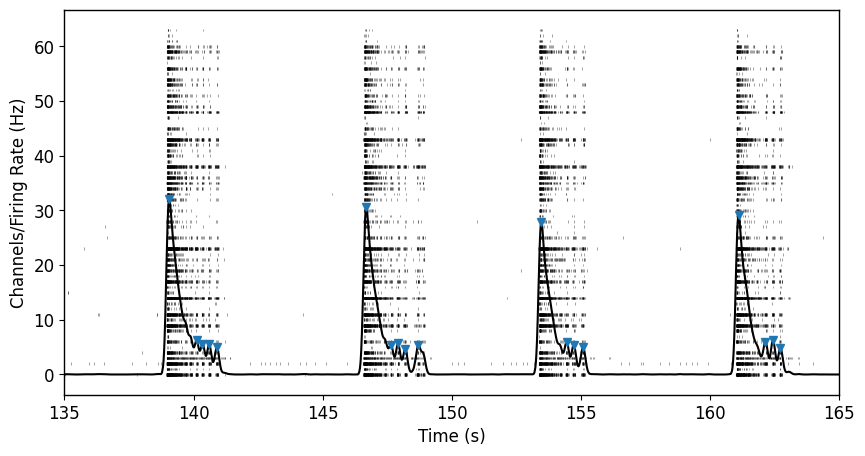

In [25]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);
t = np.arange(0,duration,1/12500)
plt.plot(t,weighted_network_sdf, color='black')
plt.xlim(135,165)
plt.ylabel("Channels/Firing Rate (Hz)")
plt.xlabel("Time (s)")

plt.plot(burst_peak_times, weighted_network_sdf[(burst_peak_times*fs).astype(int)], 'v')

As you can see, our really basic peak detection was able to identify the location of all the network bursts in this recording. Depending on how noisy your activity is, you may need a more complicated approach.

## Cluster burst peaks along inter-burst-peak-interval and firing rate dimensions

### Visualize data

Text(0, 0.5, 'Firing rate (Hz)')

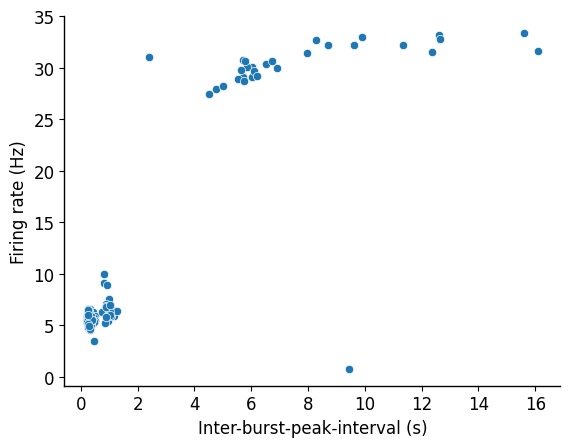

In [38]:
ibpi = np.diff(burst_peak_times)
fr = weighted_network_sdf[(burst_peak_times*fs).astype(int)]
sns.scatterplot(x=ibpi,y=fr[1:])
sns.despine()
plt.xlabel("Inter-burst-peak-interval (s)")
plt.ylabel("Firing rate (Hz)")

This approach ignores the first burst. We can deal with that later. But the important thing is that there appears to be two main clusters where expected.

### K-means clustering

In [32]:
def k_means(ibpi, fr):
  features = np.transpose([ibpi, fr[1:]])
  #scaler = StandardScaler()
  #scaled_features = scaler.fit_transform(features)

  kmeans_kwargs = {
      "init": "random",
      "n_init": 10,
      "max_iter": 250,
      "random_state": 0
  }
  kmeans = KMeans(n_clusters=2, **kmeans_kwargs)
  kmeans.fit(features)

  x = np.transpose(features)[0]
  y = np.transpose(features)[1]

  # Assign the mini-burst cluster as label 1
  if np.nanmean(x[kmeans.labels_==0]) > np.nanmean(x[kmeans.labels_==1]):
    cluster_x_1 = x[kmeans.labels_==0]
    cluster_x_2 = x[kmeans.labels_==1]
    cluster_y_1 = y[kmeans.labels_==0]
    cluster_y_2 = y[kmeans.labels_==1]
  else:
    cluster_x_1 = x[kmeans.labels_==1]
    cluster_x_2 = x[kmeans.labels_==0]
    cluster_y_1 = y[kmeans.labels_==1]
    cluster_y_2 = y[kmeans.labels_==0]
  #sns.scatterplot(x=cluster_x_1, y=cluster_y_1, color='green')
  #sns.scatterplot(x=cluster_x_2, y=cluster_y_2, color='red')

  # Check what the percent of overlap is
  num_of_bins = int(len(fr)/2)
  # Overlapping x
  rng_x = min(cluster_x_1.min(), cluster_x_2.min()), max(cluster_x_1.max(), cluster_x_2.max())
  n1_x, bins1_x = np.histogram(cluster_x_1, bins=num_of_bins, range=rng_x)
  n2_x, bins2_x = np.histogram(cluster_x_2, bins=num_of_bins, range=rng_x)
  intersection_x = np.minimum(n1_x,n2_x)

  overlapping_bins_x = np.nonzero(intersection_x)
  if len(overlapping_bins_x) > 0:
      overlapping_bursts_x = np.sum(n1_x[overlapping_bins_x] + n2_x[overlapping_bins_x])
      percent_overlapping_x = overlapping_bursts_x/len(x)
  else:
      percent_overlapping_x = 0

  if percent_overlapping_x > 0.2:
    print(f"The well is probably not reverberating strongly if at all")
    return False, x, y, kmeans.labels_
  else:
    return True, x, y, kmeans.labels_


isReverb, cluster_x, cluster_y, labels = k_means(ibpi, fr)

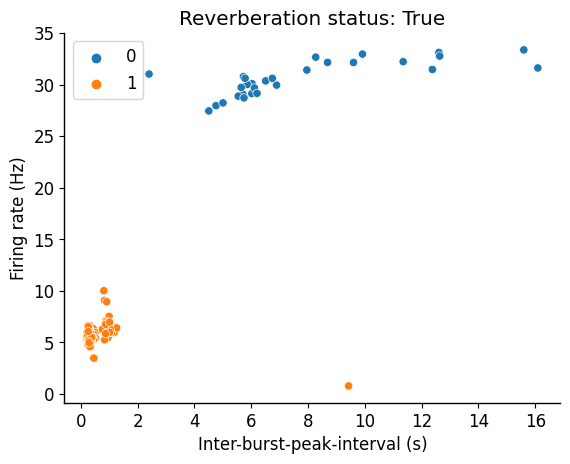

In [37]:
sns.scatterplot(x=cluster_x, y=cluster_y, hue=labels)
plt.xlabel("Inter-burst-peak-interval (s)")
plt.ylabel("Firing rate (Hz)")
plt.title(f"Reverberation status: {isReverb}")
sns.despine()